In [122]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from palmerpenguins import load_penguins
import numpy as np
from palmerpenguins import load_penguins
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures,label_binarize
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, accuracy_score, classification_report, roc_curve, auc,roc_auc_score
import plotnine as pt
from sklearn.linear_model import LogisticRegression

In [123]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha.dropna(inplace=True)
ha.head()


,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [124]:
ha.describe()

,age,sex,cp,trtbps,chol,restecg,thalach,output
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,54.347985,0.673993,0.974359,132.098901,246.860806,0.538462,149.446886,0.534799
std,9.163134,0.469611,1.030456,17.700358,52.569726,0.528059,23.240707,0.499704
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,71.000000,0.000000
25%,47.000000,0.000000,0.000000,120.000000,211.000000,0.000000,133.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.000000,1.000000,152.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.000000,1.000000,166.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,2.000000,202.000000,1.000000


# Part 1: Fitting Models

In [125]:
# Finding X and y
from sklearn.preprocessing import LabelEncoder

X = ha.drop("output", axis = 1)
# Ensure target is treated as categorical

y = ha["output"]
y = y.astype('category')  
label_encoder = LabelEncoder()
label_encoder.fit(y)
y = label_encoder.fit_transform(y)

# X_train, X_test, y_train, y_test = train_test_split(X, y)

## KNN

In [126]:
# KNN Model with K=3
ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False), ["sex", "cp", "restecg"]),
    ("standardize", StandardScaler(), ["age", "trtbps", "chol", "thalach"])
  ],
  remainder = "drop"
)

knn_pipeline = Pipeline([
    ('preprocessor', ct),
    ('knn', KNeighborsClassifier())
])

# Set up grid search to tune 'n_neighbors'
param_grid = {'knn__n_neighbors': range(1, 21)}
grid_search = GridSearchCV(knn_pipeline, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X, y)

best_k = grid_search.best_params_['knn__n_neighbors']
final_pipeline = Pipeline([
    ('preprocessor', ct),
    ('knn', KNeighborsClassifier(n_neighbors=best_k))
])
final_model = final_pipeline.fit(X, y)

In [127]:
knn1 = knn_pipeline.fit(X, y)

y_train_pred = knn1.predict(X)
# y_test_pred = knn1.predict(X_test)



y_train_prob = final_model.predict_proba(X)[:, 1]
y_train_pred_knn = final_model.predict(X)

# ROC AUC score
roc_auc = roc_auc_score(y, y_train_prob)
print("ROC AUC on Test Set:", roc_auc)


conf_matrix = confusion_matrix(y, y_train_pred_knn)
print("\nConfusion Matrix:\n", conf_matrix)

ROC AUC on Test Set: 0.8551666486894618

Confusion Matrix:
 [[104  23]
 [ 36 110]]


## Logistic Regression

In [128]:
# Logistic regression pipeline
logreg_pipeline = Pipeline([
    ('preprocessor', ct),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

# Fit the model on training data
logreg_model = logreg_pipeline.fit(X, y)

cv_scores = cross_val_score(logreg_pipeline, X, y, cv=5, scoring='roc_auc')

final_logreg_model = logreg_pipeline.fit(X, y)


y_train_prob = final_logreg_model.predict_proba(X)[:, 1]  # Probabilities for ROC
y_train_pred_log = final_logreg_model.predict(X)

# ROC AUC on test set
roc_auc = roc_auc_score(y, y_train_prob)
print("Test Set ROC AUC:", roc_auc)

# Confusion Matrix
conf_matrix = confusion_matrix(y, y_train_pred_log)
print("\nConfusion Matrix:\n", conf_matrix)


feature_names = logreg_pipeline.named_steps['preprocessor'].get_feature_names_out()
coefficients = logreg_pipeline.named_steps['logreg'].coef_[0]

# Pair features with coefficients
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef:.4f}")

Test Set ROC AUC: 0.8820515586236652

Confusion Matrix:
 [[ 96  31]
 [ 24 122]]
dummify__sex_0: 0.9960
dummify__sex_1: -0.9967
dummify__cp_0: -1.4055
dummify__cp_1: 0.6116
dummify__cp_2: 0.4830
dummify__cp_3: 0.3102
dummify__restecg_0: -0.0333
dummify__restecg_1: 0.2991
dummify__restecg_2: -0.2665
standardize__age: -0.2322
standardize__trtbps: -0.3225
standardize__chol: -0.2740
standardize__thalach: 0.7615


Chat GPT-4o was used to find the coefficient values and put them into a usable format.

Keeping the other variables constant, every increase in 1 standard deviation in age decreases the log-odds of being diagnosed with heart disease by 0.31. Having a chest pain diagnosis of 2 increases the log-odds of being diagnosed with heart disease by 0.64.

## Decision Tree

In [129]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, roc_curve

# Decision Tree pipeline
dt_pipeline = Pipeline([
    ('preprocessor', ct),
    ('dt', DecisionTreeClassifier(random_state=42))
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'dt__max_depth': range(1,21)
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    dt_pipeline,
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)
grid_search.fit(X, y)

# Best parameters and cross-validated ROC AUC score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated ROC AUC:", grid_search.best_score_)

# Refit the model with the best parameters
best_dt_pipeline = grid_search.best_estimator_
final_model1 = best_dt_pipeline.fit(X, y)

# Predictions and probabilities for the test set
y_train_prob = final_model1.predict_proba(X)[:, 1]  # Probabilities for ROC
y_train_pred_dec = final_model1.predict(X)

# ROC AUC on the test set
roc_auc = roc_auc_score(y, y_train_prob)
print("Test Set ROC AUC:", roc_auc)

# Confusion Matrix
conf_matrix = confusion_matrix(y, y_train_pred_dec)
print("\nConfusion Matrix:\n", conf_matrix)


Best parameters: {'dt__max_depth': 2}
Best cross-validated ROC AUC: 0.7720629531388152
Test Set ROC AUC: 0.8238323805414735

Confusion Matrix:
 [[ 94  33]
 [ 34 112]]


## Interpretation

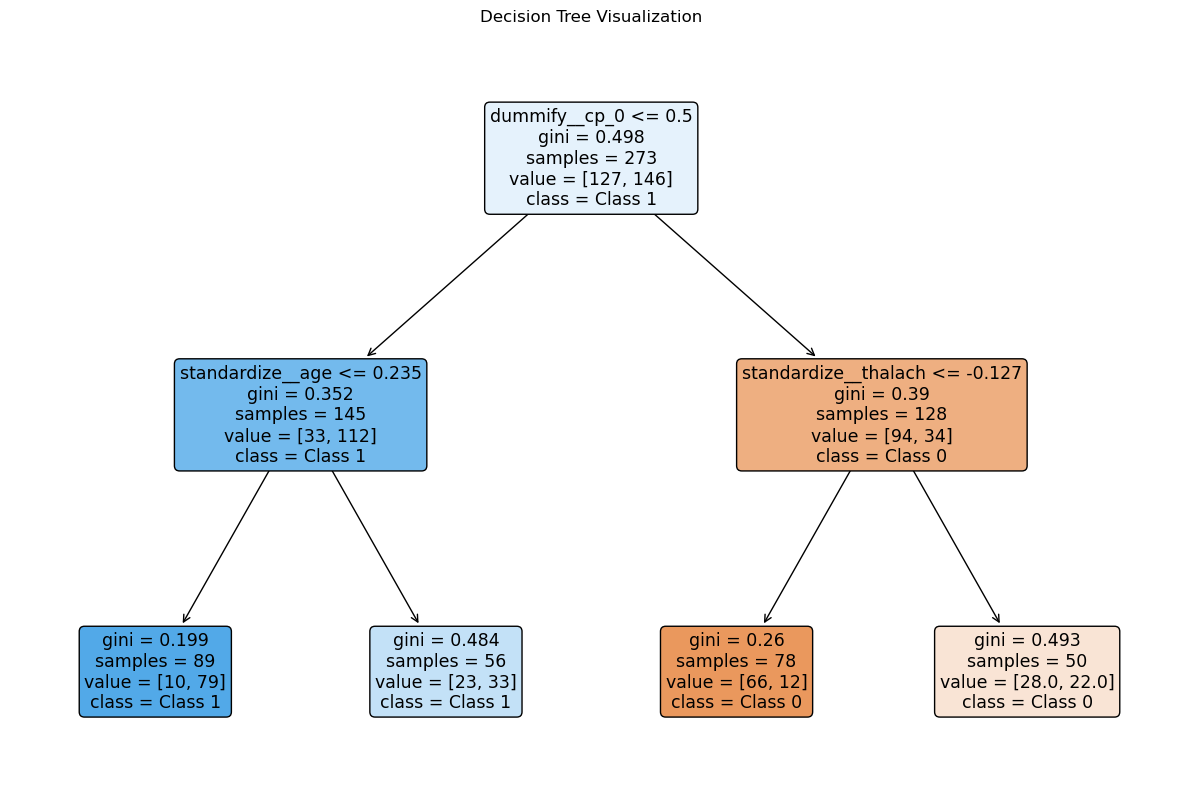

In [130]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Extract the trained decision tree from the pipeline
decision_tree = final_model1.named_steps['dt']

# Plot the decision tree
plt.figure(figsize=(15, 10))
plot_tree(decision_tree, filled=True, feature_names=ct.get_feature_names_out(), class_names=["Class 0", "Class 1"], rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

According to the decision tree, sex is the most important variable to predict heart disease diagnosis. This is because it was the first split on the decision tree. Other important variables are maximum heart rate achieved during exercise and age.

## ROC Curve

In [131]:
knn_prob = final_model.predict_proba(X)[:, 1]
knn_fpr, knn_tpr, _ = roc_curve(y, knn_prob)
knn_auc = roc_auc_score(y, knn_prob)

# Logistic Regression ROC Curve
logreg_prob = final_logreg_model.predict_proba(X)[:, 1]
logreg_fpr, logreg_tpr, _ = roc_curve(y, logreg_prob)
logreg_auc = roc_auc_score(y, logreg_prob)

# Decision Tree ROC Curve
dt_prob = final_model1.predict_proba(X)[:, 1]
dt_fpr, dt_tpr, _ = roc_curve(y, dt_prob)
dt_auc = roc_auc_score(y, dt_prob)


roc_data = pd.DataFrame({
    'FPR': list(knn_fpr) + list(logreg_fpr) + list(dt_fpr),
    'TPR': list(knn_tpr) + list(logreg_tpr) + list(dt_tpr),
    'Model': (
        ['KNN (AUC = {:.2f})'.format(knn_auc)] * len(knn_fpr) +
        ['Logistic Regression (AUC = {:.2f})'.format(logreg_auc)] * len(logreg_fpr) +
        ['Decision Tree (AUC = {:.2f})'.format(dt_auc)] * len(dt_fpr)
    )
})

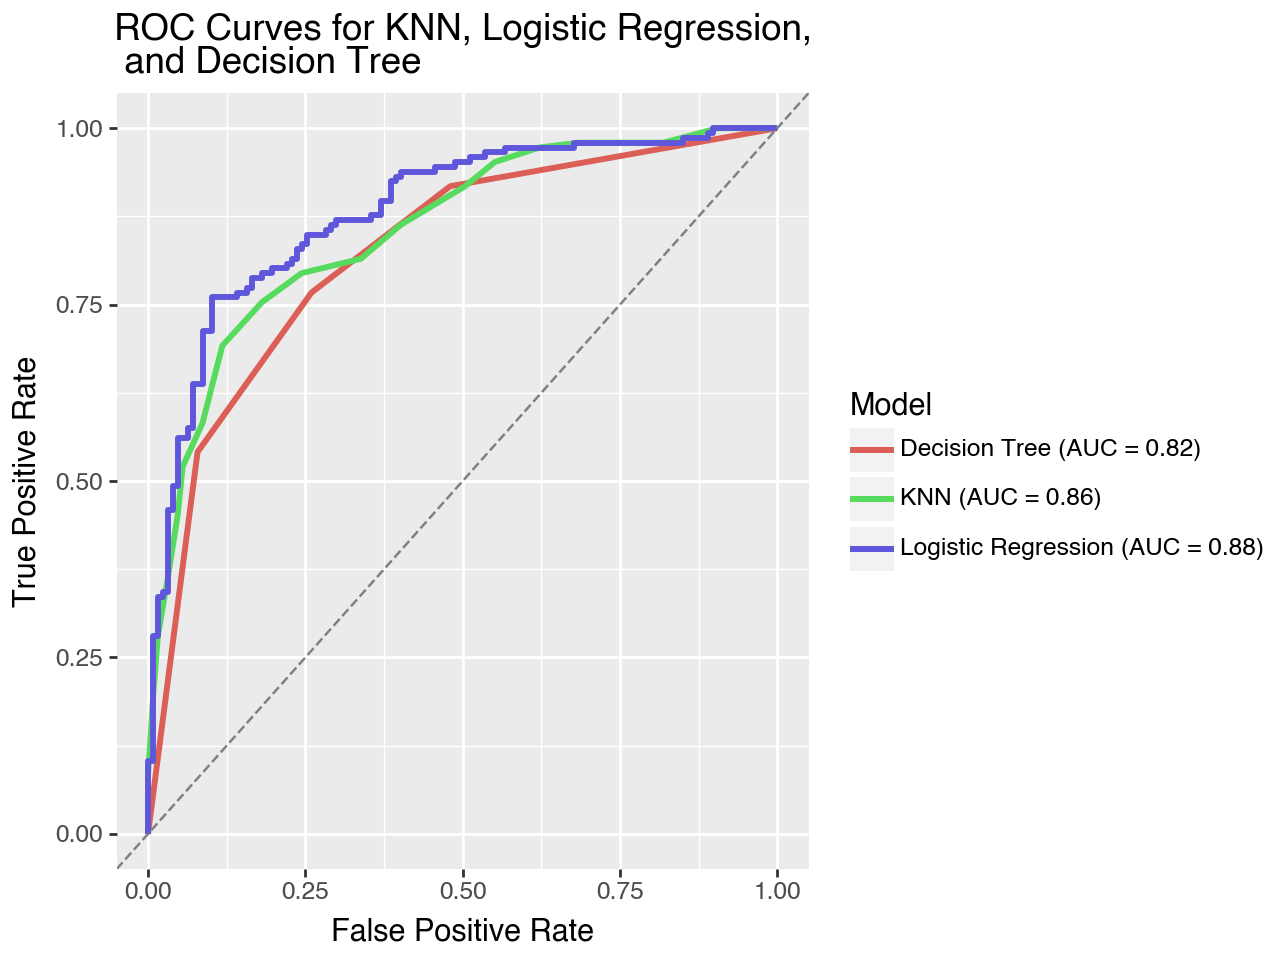

In [132]:
(
    pt.ggplot(roc_data, pt.aes(x='FPR', y='TPR', color='Model')) +
    pt.geom_line(size=1.2) +
    pt.geom_abline(linetype='dashed', color='gray') + 
    pt.labs(
        title='ROC Curves for KNN, Logistic Regression,\n and Decision Tree',
        x='False Positive Rate',
        y='True Positive Rate'
    )
)

# Part 2: Metrics

In [133]:
#Finding Metrics
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, recall_score, precision_score

knn_pred = cross_val_predict(knn_pipeline, X, y, cv=5)
logreg_pred = cross_val_predict(logreg_pipeline, X, y, cv=5)
dt_pred = cross_val_predict(best_dt_pipeline, X, y, cv=5)

knn_recall = recall_score(y, knn_pred)
logreg_recall = recall_score(y, logreg_pred)
dt_recall = recall_score(y, dt_pred)

knn_precision = precision_score(y, knn_pred)
logreg_precision = precision_score(y, logreg_pred)
dt_precision = precision_score(y, dt_pred)

knn_cm = confusion_matrix(y, knn_pred)
logreg_cm = confusion_matrix(y, logreg_pred)
dt_cm = confusion_matrix(y, dt_pred)

knn_tn, knn_fp, _, _ = knn_cm.ravel()
logreg_tn, logreg_fp, _, _ = logreg_cm.ravel()
dt_tn, dt_fp, _, _ = dt_cm.ravel()

knn_spec = knn_tn / (knn_tn + knn_fp)
logreg_spec = logreg_tn / (logreg_tn + logreg_fp)
dt_spec = dt_tn / (dt_tn + dt_fp)

In [134]:
metrics_df = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Decision Tree'],
    'True Positive Rate (Recall)': [knn_recall, logreg_recall, dt_recall],
    'Precision': [knn_precision, logreg_precision, dt_precision],
    'True Negative Rate (Specificity)': [knn_spec, logreg_spec, dt_spec]
})
metrics_df

,Model,True Positive Rate (Recall),Precision,True Negative Rate (Specificity)
0,KNN,0.684932,0.724638,0.700787
1,Logistic Regression,0.815068,0.793333,0.755906
2,Decision Tree,0.767123,0.761905,0.724409


## Part 3: Discussion

Q1:
I would focus on the sensitivity/recall. This factors in the amount of false negatives which are the most harmful in this situation. We should pick the Logistic Regression Model because it has the highest sensitivity. Using this model, we expect the ROC AUC value to be 0.82. 

Q2:
For this question, I would focus on the precision and the specificity. The precision would probably be the most important metric because it relies on the accuracy of true positives. This way, there would be fewer people using hospital beds who don't need them. For this problem, we should also use Logistic Regression because it has the highest precision and specificity. We can expect a ROC AUC value of 0.82. 

Q3: 
Now, I would look at interpreting the results of the model. In this case, I would either look at Logistic Regression or the Decision Tree. Logistic Regression would be useful because it is the best model, and we can look at the value of coefficients to see which has the largest impact. This could get tricky with correlations between different coefficients, so we could also use the Decision Tree and determine which order the tree gets split in. Variables that are split earlier in the tree are usually more important than later ones.

Q4:
For this question, I think looking at a combination of the metrics is appropriate. For a doctor, a false negative and a false positive are both bad things, so looking at a combination is important. We could also use a combination of our models to answer this. On one hand, the Logistic Regression model is the most accurate, so it is definitely a valid choice. However, the KNN and Decision Tree models align well with the process in which doctors diagnose patients, so they would also be good options. Both the Decision Tree and the KNN model are still very accurate, so if a doctor could mimic one of the models in their own diagnosis, they would be considered very successful.

## Part 4: Validation

In [135]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")
ha_validation.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,41,0,1,130,204,0,172,1
1,64,1,3,110,211,0,144,1
2,59,1,0,135,234,1,161,1
3,42,1,0,140,226,1,178,1
4,40,1,3,140,199,1,178,1


In [136]:
X_validation = ha_validation.drop(columns=["output"]) 
y_validation = ha_validation["output"]

In [137]:
# Logistic Regression model (assuming it's called 'final_logreg_model')
logreg_pred = final_logreg_model.predict(X_validation)
logreg_prob = final_logreg_model.predict_proba(X_validation)[:, 1]

# Confusion Matrix
logreg_cm = confusion_matrix(y_validation, logreg_pred)
print("\nLogistic Regression Confusion Matrix:")
print(logreg_cm)

# ROC AUC
logreg_roc_auc = roc_auc_score(y_validation, logreg_prob)
print(f"Logistic Regression ROC AUC: {logreg_roc_auc:.4f}")

# Precision and Recall
logreg_precision = precision_score(y_validation, logreg_pred)
logreg_recall = recall_score(y_validation, logreg_pred)
print(f"Logistic Regression Precision: {logreg_precision:.4f}")
print(f"Logistic Regression Recall: {logreg_recall:.4f}")


Logistic Regression Confusion Matrix:
[[ 9  2]
 [ 5 14]]
Logistic Regression ROC AUC: 0.8852
Logistic Regression Precision: 0.8750
Logistic Regression Recall: 0.7368


In [138]:
# KNN model (assuming it's called 'knn1')
knn_pred = knn1.predict(X_validation)
knn_prob = knn1.predict_proba(X_validation)[:, 1]

# Confusion Matrix
knn_cm = confusion_matrix(y_validation, knn_pred)
print("\nKNN Confusion Matrix:")
print(knn_cm)

# ROC AUC
knn_roc_auc = roc_auc_score(y_validation, knn_prob)
print(f"KNN ROC AUC: {knn_roc_auc:.4f}")

# Precision and Recall
knn_precision = precision_score(y_validation, knn_pred)
knn_recall = recall_score(y_validation, knn_pred)
print(f"KNN Precision: {knn_precision:.4f}")
print(f"KNN Recall: {knn_recall:.4f}")



KNN Confusion Matrix:
[[ 9  2]
 [ 6 13]]
KNN ROC AUC: 0.8158
KNN Precision: 0.8667
KNN Recall: 0.6842


In [139]:
# Decision Tree model (assuming it's called 'final_model')
dt_pred = final_model.predict(X_validation)
dt_prob = final_model.predict_proba(X_validation)[:, 1]

# Confusion Matrix
dt_cm = confusion_matrix(y_validation, dt_pred)
print("\nDecision Tree Confusion Matrix:")
print(dt_cm)

# ROC AUC
dt_roc_auc = roc_auc_score(y_validation, dt_prob)
print(f"Decision Tree ROC AUC: {dt_roc_auc:.4f}")

# Precision and Recall
dt_precision = precision_score(y_validation, dt_pred)
dt_recall = recall_score(y_validation, dt_pred)
print(f"Decision Tree Precision: {dt_precision:.4f}")
print(f"Decision Tree Recall: {dt_recall:.4f}")


Decision Tree Confusion Matrix:
[[ 9  2]
 [ 8 11]]
Decision Tree ROC AUC: 0.8756
Decision Tree Precision: 0.8462
Decision Tree Recall: 0.5789


The Logistic Regression still has the highest ROC AUC value, so it was still the most accurate model. In general, the ROC AUC values increased a little bit, the precision values increased, and the recall values decreased. Now, the model with the best precision is the Decision tree while the Logistic Model is the best for the rest of the metrics. The metrics definitely changed because we were applying it to new data, but the results were not very surprising and show that the analysis was correct.

## Part 5: Cohen's Kappa

In [141]:
from sklearn.metrics import cohen_kappa_score

# Assume y_true is the true labels and y_pred is the predicted labels
kappa = cohen_kappa_score(y, y_train_pred_knn)
print(f"Cohen's Kappa KNN: {kappa}")


kappa = cohen_kappa_score(y, y_train_pred_log)
print(f"Cohen's Kappa Logistic Regression: {kappa}")


kappa = cohen_kappa_score(y, y_train_pred_dec)
print(f"Cohen's Kappa Decision Trees: {kappa}")


Cohen's Kappa KNN: 0.568535533470842
Cohen's Kappa Logistic Regression: 0.5936510513923845
Cohen's Kappa Decision Trees: 0.5070209956068242


The Cohen's Kappa value for the Logistic Regression was the highest coming in at 0.59. This means the Logistic Regression did a fairly good job of predicting classes correctly. This metric is primarily used when there are uneven class weights, and it can also serve as a metric that does not succumb to random chance. Since we have multiple classifiers in this problem, Cohen's Kappa is actually a useful metric. Additionally, our classes are not completely equal in size, so Cohen's Kappa will be useful in leveling that out. For this heart disease dataset, I think Cohen's Kappa definitely has a place, but depending on the priorities of the problem at hand, it should not be the only metric used and not necessarily the most important metric either. The question at hand should be examined first before determining which metrics are the most important.

Chat GPT 4o was used to help with unknown calculations and syntax errors as well as automation for different models.